# Week 3 — Prompt Optimization & Ablations on EuroSAT (OpenCLIP + HF Datasets)

**Goals**
- Systematically test prompt templates (and optional synonyms).
- Compare single prompts vs. prompt ensembles.
- Report per-class sensitivity + pick a best prompt set.

**Inputs**
- Same HF EuroSAT val split from Weeks 1–2.
- Same model/weights as Week 1–2 (change if you want).

**Outputs**
- Table of prompt → Top-1/Top-5
- Per-class accuracy heatmap across prompts
- Best single prompt vs. ensemble
- Artifacts in `../results/prompt_exp`

In [26]:
import os, math, json, random
from pathlib import Path
from typing import List, Dict
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, top_k_accuracy_score

import open_clip
from datasets import load_dataset, DatasetDict
from PIL import Image

# Repro & device
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model (same as Week 2; feel free to bump to ViT-L/14 for stronger results)
MODEL_NAME = "ViT-B-32"
PRETRAINED = "laion2b_s34b_b79k"

# Data split
HOLDOUT_FRACTION = 0.2  # must match Week 1–2 for apples-to-apples

# Prompts under test (edit/add freely)
PROMPT_TEMPLATES = [
    "a satellite photo of {label}.",
    "an aerial view of {label}.",
    "satellite image showing {label}.",
    "a remote sensing image of {label}.",
    "an overhead view of {label}.",
    "a high-resolution satellite image of {label}.",
    "remote sensing imagery showing {label}.",
    "a Sentinel-2 style satellite image of {label}.",
]

# Optional: label synonyms per EuroSAT class (extend/adjust as you like)
USE_SYNONYMS = True
LABEL_SYNONYMS = {
    "annual crop": ["annual crop", "farmland", "agricultural field"],
    "forest": ["forest", "woodland"],
    "highway": ["highway", "motorway", "freeway"],
    "industrial": ["industrial area", "industrial zone", "factories"],
    "pasture": ["pasture", "grassland", "meadow"],
    "permanent crop": ["permanent crop", "orchard", "vineyard"],
    "residential": ["residential area", "housing area", "suburban neighborhood"],
    "river": ["river", "waterway"],
    "sea lake": ["sea or lake", "body of water", "lake or sea"],
    "herbaceous vegetation": ["herbaceous vegetation", "shrubs", "bushland"],
}

# Results dir
OUTDIR = Path("../results/prompt_exp") / f"{MODEL_NAME}_synonyms{int(USE_SYNONYMS)}_seed{SEED}"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Device:", DEVICE)
print("Output:", OUTDIR.resolve())

Device: cuda
Output: /home/oshri/code/clip-rs-fewshot/results/prompt_exp/ViT-B-32_synonyms1_seed42


In [27]:
ds_raw = load_dataset("nielsr/eurosat-demo")
ds_split = ds_raw["train"].train_test_split(test_size=HOLDOUT_FRACTION, seed=SEED, stratify_by_column="label")
ds = DatasetDict({"train": ds_split["train"], "val": ds_split["test"]})
print(ds)

label_names = [n.replace("_", " ") for n in ds["train"].features["label"].names]
num_classes = len(label_names)
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
print("Classes:", num_classes)
print(id2label)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})
Classes: 10
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [28]:
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=PRETRAINED,
    device=DEVICE
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model.eval()

# quick warmup (optional)
with torch.no_grad():
    sz = getattr(getattr(model, "visual", None), "image_size", 224)
    if isinstance(sz, int): h = w = sz
    else: h, w = int(sz[0]), int(sz[1])
    _ = model.encode_image(torch.zeros(1,3,h,w, device=DEVICE))
print("Model ready:", MODEL_NAME, PRETRAINED)

Model ready: ViT-B-32 laion2b_s34b_b79k


In [29]:
class HFEuroSATDataset(Dataset):
    def __init__(self, hf_ds, preprocess):
        self.ds = hf_ds
        self.preprocess = preprocess
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[int(idx)]
        x = self.preprocess(ex["image"])
        y = ex["label"]
        return x, y

def collate_tensor_batch(batch):
    xs = torch.stack([b[0] for b in batch], dim=0)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys

def val_loader(batch_size=128):
    return DataLoader(HFEuroSATDataset(ds["val"], preprocess),
                      batch_size=batch_size, shuffle=False, collate_fn=collate_tensor_batch)

In [30]:
def build_prompt_texts(template: str, labels: List[str]) -> List[str]:
    return [template.format(label=l) for l in labels]

@torch.no_grad()
def encode_texts(texts: List[str]) -> torch.Tensor:
    tok = tokenizer(texts).to(DEVICE)
    with torch.amp.autocast('cuda'):
        tf = model.encode_text(tok)    # [N, D]
    tf = tf / tf.norm(dim=-1, keepdim=True)
    return tf

@torch.no_grad()
def text_features_for_template(template: str) -> torch.Tensor:
    """Return [C, D] text features for the class list under this template.
       If USE_SYNONYMS: average synonyms per class first."""
    if not USE_SYNONYMS:
        texts = build_prompt_texts(template, [id2label[i] for i in range(num_classes)])
        return encode_texts(texts)  # [C, D]

    # synonyms path
    feats = []
    for i in range(num_classes):
        label = id2label[i]
        syns = LABEL_SYNONYMS.get(label, [label])
        texts = build_prompt_texts(template, syns)
        tf = encode_texts(texts)           # [S, D]
        feats.append(tf.mean(dim=0, keepdim=True))
    return torch.cat(feats, dim=0)         # [C, D]

In [31]:
from tqdm import tqdm

@torch.no_grad()
def evaluate_prompts(templates: List[str], batch_size=128):
    # Precompute text feats per template
    t_by_tpl = [text_features_for_template(tpl) for tpl in templates]  # list of [C,D]
    loader = val_loader(batch_size=batch_size)

    y_true, y_pred = [], []
    logits_all = []

    for xb, yb in tqdm(loader, total=math.ceil(len(ds["val"])/batch_size), desc="Eval"):
        xb = xb.to(DEVICE)
        with torch.amp.autocast('cuda'):
            f = model.encode_image(xb)     # [B,D]
        f = f / f.norm(dim=-1, keepdim=True)

        # logits per template, then average (ensemble)
        logits_tpl = [(f @ t.t()) for t in t_by_tpl]  # list of [B,C]
        logits = torch.stack(logits_tpl, dim=0).mean(dim=0)

        y_true.extend(yb.tolist())
        y_pred.extend(logits.argmax(dim=-1).tolist())
        logits_all.append(logits.cpu())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    logits_all = torch.cat(logits_all, dim=0).numpy()

    top1 = (y_true == y_pred).mean().item()
    top5 = top_k_accuracy_score(y_true, logits_all, k=5)
    cm   = confusion_matrix(y_true, y_pred, labels=list(range(num_classes))).tolist()
    return {"top1": float(top1), "top5": float(top5), "cm": cm}

In [32]:
results = {}

# single templates
for tpl in PROMPT_TEMPLATES:
    print("\nSingle:", tpl)
    res = evaluate_prompts([tpl], batch_size=128)
    results[f"single::{tpl}"] = res
    print(f"Top-1: {res['top1']*100:.2f}% | Top-5: {res['top5']*100:.2f}%")

# full ensemble
print("\nEnsemble: average over ALL templates")
res_ens = evaluate_prompts(PROMPT_TEMPLATES, batch_size=128)
results["ensemble::all"] = res_ens
print(f"Top-1: {res_ens['top1']*100:.2f}% | Top-5: {res_ens['top5']*100:.2f}%")

# save
with open(OUTDIR / "week3_prompt_results.json", "w") as f:
    json.dump({"config":{
        "model_name": MODEL_NAME, "pretrained": PRETRAINED,
        "use_synonyms": USE_SYNONYMS, "prompts": PROMPT_TEMPLATES,
        "seed": SEED
    }, "results": results}, f, indent=2)
print("Saved:", (OUTDIR / "week3_prompt_results.json").resolve())



Single: a satellite photo of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  6.08it/s]


Top-1: 41.19% | Top-5: 86.50%

Single: an aerial view of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.74it/s]


Top-1: 44.50% | Top-5: 92.85%

Single: satellite image showing {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.99it/s]


Top-1: 40.31% | Top-5: 87.24%

Single: a remote sensing image of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.88it/s]


Top-1: 40.48% | Top-5: 81.33%

Single: an overhead view of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.99it/s]


Top-1: 36.07% | Top-5: 91.11%

Single: a high-resolution satellite image of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]


Top-1: 42.52% | Top-5: 85.11%

Single: remote sensing imagery showing {label}.


Eval: 100%|██████████| 43/43 [00:06<00:00,  6.27it/s]


Top-1: 41.04% | Top-5: 79.50%

Single: a Sentinel-2 style satellite image of {label}.


Eval: 100%|██████████| 43/43 [00:07<00:00,  5.96it/s]


Top-1: 42.70% | Top-5: 83.93%

Ensemble: average over ALL templates


Eval: 100%|██████████| 43/43 [00:06<00:00,  6.20it/s]

Top-1: 41.93% | Top-5: 88.94%
Saved: /home/oshri/code/clip-rs-fewshot/results/prompt_exp/ViT-B-32_synonyms1_seed42/week3_prompt_results.json


In [33]:
import pandas as pd

rows = []
for k, v in results.items():
    rows.append({"setting": k, "top1": v["top1"], "top5": v["top5"]})
df = pd.DataFrame(rows).sort_values("top1", ascending=False)
display(df.style.format({"top1":"{:.3f}", "top5":"{:.3f}"}))

best_row = df.iloc[0]
best_name = best_row["setting"]
print("Best setting:", best_name, "| Top-1 = {:.2f}% | Top-5 = {:.2f}%".format(best_row["top1"]*100, best_row["top5"]*100))
df.to_csv(OUTDIR / "week3_prompt_summary.csv", index=False)

,setting,top1,top5
1,single::an aerial view of {label}.,0.445,0.929
7,single::a Sentinel-2 style satellite image of {label}.,0.427,0.839
5,single::a high-resolution satellite image of {label}.,0.425,0.851
8,ensemble::all,0.419,0.889
0,single::a satellite photo of {label}.,0.412,0.865
6,single::remote sensing imagery showing {label}.,0.410,0.795
3,single::a remote sensing image of {label}.,0.405,0.813
2,single::satellite image showing {label}.,0.403,0.872
4,single::an overhead view of {label}.,0.361,0.911


Best setting: single::an aerial view of {label}. | Top-1 = 44.50% | Top-5 = 92.85%


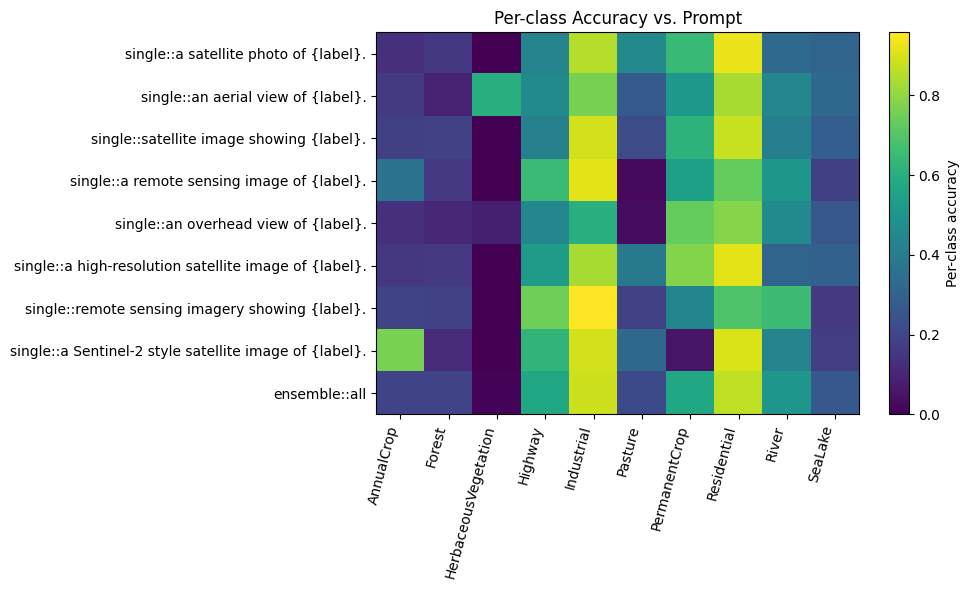

In [39]:
# Compute per-class accuracy for each prompt to visualize sensitivity
def per_class_acc(cm):
    cm = np.array(cm)
    return np.diag(cm) / cm.sum(axis=1).clip(min=1)

labels = [id2label[i] for i in range(num_classes)]
prompt_keys = [k for k in results.keys() if k.startswith("single::")]
prompt_keys.append("ensemble::all")

heat = []
for key in prompt_keys:
    accs = per_class_acc(results[key]["cm"])
    heat.append(accs)
heat = np.stack(heat, axis=0)  # [P, C]

fig = plt.figure(figsize=(max(10, len(labels)*0.4), max(6, len(prompt_keys)*0.35)))
plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.colorbar(label="Per-class accuracy")
plt.yticks(ticks=np.arange(len(prompt_keys)), labels=prompt_keys)
plt.xticks(ticks=np.arange(num_classes), labels=labels, rotation=75, ha="right")
plt.title("Per-class Accuracy vs. Prompt")
plt.tight_layout()
plt.show()
fig.savefig(OUTDIR / "per_class_heatmap.png", bbox_inches='tight', dpi=200)

## What to look for
- Which **single prompt** works best overall?
- Does the **ensemble** help (often +1–4 pts)?
- Which **classes** are most sensitive to phrasing? (See the heatmap.)

## Quick extra experiments (optional)
- Try **without** synonyms vs. **with** synonyms and compare.
- Add a small set of **class-specific prompts** (e.g., “a vineyard” for permanent crop).
- Evaluate with a **larger model** (ViT-L/14) for a higher ceiling.

## Artifacts
- `results/prompt_exp/week3_prompt_results.json`
- `results/prompt_exp/week3_prompt_summary.csv`
- `results/prompt_exp/per_class_heatmap.png`